__<h2>Importing Libraries </h2>__

In [1]:
import keras
import os
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from sklearn.model_selection import StratifiedKFold

**Grid View**

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

**Variable Defining**

In [4]:
SAMPLE_PER_CATEGORY = 200
SEED = 42 # fixed point
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

**Input Directory**

In [5]:
data_dir = '../input/brain-tumor-mri-dataset/'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

**Defining categories**

In [6]:
CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

**Training sample data set info**

In [7]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

glioma 1321 images
meningioma 1339 images
notumor 1595 images
pituitary 1457 images


In [8]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size) ## https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img
    img = image.img_to_array(img)
    return img

****Creating Dataframe of the Dataset****

In [9]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['Training/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(5712, 3)

In [10]:
train['category_id'].value_counts()

2    1595
3    1457
1    1339
0    1321
Name: category_id, dtype: int64

In [14]:
train.head(10)

,file,category_id,category
0,Training/glioma/Tr-gl_0954.jpg,0,glioma
1,Training/glioma/Tr-gl_0959.jpg,0,glioma
2,Training/glioma/Tr-gl_1033.jpg,0,glioma
3,Training/glioma/Tr-gl_1096.jpg,0,glioma
4,Training/glioma/Tr-gl_1290.jpg,0,glioma
5,Training/glioma/Tr-gl_0042.jpg,0,glioma
6,Training/glioma/Tr-gl_0806.jpg,0,glioma
7,Training/glioma/Tr-gl_0888.jpg,0,glioma
8,Training/glioma/Tr-gl_0157.jpg,0,glioma
9,Training/glioma/Tr-gl_0543.jpg,0,glioma


__<h2> Generating vector for training samples taking equal number of images from each category </h2>__

In [17]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.shape

(800, 3)

In [18]:
train.head()

,file,category_id,category
0,Training/notumor/Tr-no_0590.jpg,2,notumor
1,Training/glioma/Tr-gl_1203.jpg,0,glioma
2,Training/pituitary/Tr-pi_0713.jpg,3,pituitary
3,Training/glioma/Tr-gl_0427.jpg,0,glioma
4,Training/pituitary/Tr-pi_0393.jpg,3,pituitary


**Understanding test-set**

In [19]:
# printing types of files and no. of columns in test-set

test = []
for file in os.listdir(test_dir):
    test.append(['testDatasets/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.shape

(4, 2)

In [21]:
test.head

<bound method NDFrame.head of                   filepath        file
0   testDatasets/pituitary   pituitary
1     testDatasets/notumor     notumor
2  testDatasets/meningioma  meningioma
3      testDatasets/glioma      glioma>

**Generating example images**

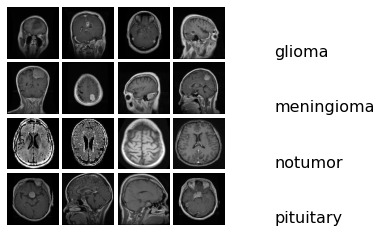

In [22]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [24]:
np.random.seed(seed=SEED)

__<h2> VGG-19 model layers identification </h2>__

In [25]:
def setTrainableLayersVGG(vgg_model):
    set_trainable = False
    for layer in vgg_model.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True  # https://keras.io/guides/transfer_learning/ , bias active
            
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return vgg_model

In [26]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model = setTrainableLayersVGG(vgg_model)
# vgg_model.trainable = False
# for layer in vgg_model.layers:
#     layer.trainable = False

pd.set_option('max_colwidth', -1) # dataframe for layer training visualization
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

2022-10-30 12:45:12.734538: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


80150528/80134624 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == "":


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7efdd4f6edd0>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7efdce4d8b50>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7efdce4dacd0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7efdce722590>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7efdce6db6d0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7efdce6e4450>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7efdce6e00d0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7efdce6e9f50>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7efdce6f3450>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7efdce6f8890>,block3_conv3,False


__<h2>ResNet-50 model identification</h2>__

In [28]:
def setTrainableLayersResNet(resnet_model):
    set_trainable = False
    for layer in resnet_model.layers:
        if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
            set_trainable = True
            
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return resnet_model

In [29]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet_model = Model(resnet.input, output)

setTrainableLayersResNet(resnet_model)
# resnet_model.trainable = False
# for layer in resnet_model.layers:
#     layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in resnet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

94781440/94765736 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == "":


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7efdce683590>,input_2,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7efdce683b50>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7efdce683dd0>,conv1_conv,False
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7efdce682250>,conv1_bn,False
4,<keras.layers.core.Activation object at 0x7efdcffac210>,conv1_relu,False
...,...,...,...
171,<keras.layers.convolutional.Conv2D object at 0x7efdbcf35050>,conv5_block3_3_conv,False
172,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7efdbcf1cd90>,conv5_block3_3_bn,False
173,<keras.layers.merge.Add object at 0x7efdbceff3d0>,conv5_block3_add,False
174,<keras.layers.core.Activation object at 0x7efdbcf78d10>,conv5_block3_out,False


**Print function for training history**

In [54]:
def printHistory(history, title, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

<h2>Categorical Cross Entropy vs Sparse Cross Entropy</h2>

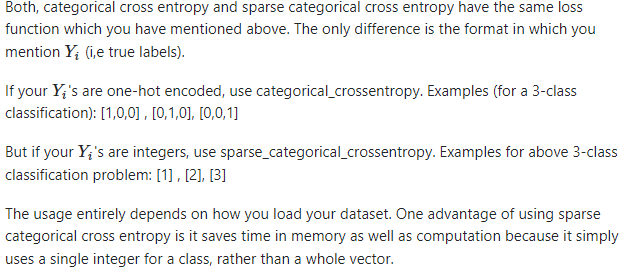

# Create model from scratch

In [55]:

def createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs):
    print("Create Model")

    transfer_model = 0 # just define
    
    if pretrainedModel == "ResNet-50":
        transfer_model = ResNet50(weights='imagenet', input_shape=INPUT_SHAPE, include_top=False)
        if fineTune == True:
            transfer_model = setTrainableLayersResNet(tranfer_model)
        else:
            for layer in transfer_model.layers:
                transfer_model.trainable = False  # freeze feature extracting layers
    elif pretrainedModel == "VGG-19":
        transfer_model = VGG19(weights='imagenet', input_shape=INPUT_SHAPE, include_top=False)
        
        if fineTune == True:
            transfer_model = setTrainableLayersVGG(tranfer_model)
        else:
            for layer in transfer_model.layers:
                layer.trainable = False  # freeze feature extracting layers

    output = transfer_model.layers[-1].output
    output = keras.layers.Flatten()(output)
    trans_model = Model(transfer_model.input, output)

    model = Sequential()
    model.add(trans_model)
    
    for i in range(0,number_of_hidden_layers):
        model.add(Dense(512))
        model.add(Activation(activation))
        model.add(Dropout(0.3))

    model.add(Dense(4, activation='softmax')) # 4 category 4 dense layer

    if optimizer == 'SGD':
        opt = SGD(learning_rate =learning_rate, decay=learning_rate / epochs)
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate, decay=learning_rate / epochs)

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) # Categorical crossentropy is a loss function that is used in multi-class classification tasks. These are tasks where an example can only belong to one out of many possible categories, and the model must decide which one. Formally, it is designed to quantify the difference between two probability distributions.
    return model

In [56]:
#callbacks for keras modal
def get_callbacks(patience):
    print("Get Callbacks")

    lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=1e-5, patience=patience, verbose=1)
    #msave = ModelCheckpoint(filepath, save_best_only=True)
    return [lr_reduce, EarlyStopping()]

**This callback logs events for TensorBoard, including:
Metrics summary plots,
Training graph visualization,
Weight histograms,
Sampled profiling**

In [57]:
def trainModelDF(images, pretrainedModel, fineTune, epochs, batch_size, learning_rate, cross_validation_folds, activation, number_of_hidden_layers, optimizer):
    print("Train Model")
    
    #augmentation
    datagen_train = ImageDataGenerator(rescale=1./255)
    
    datagen_valid = ImageDataGenerator(rescale=1./255)
        
    print("Cross validation")  #Cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. Use cross-validation to detect overfitting, ie, failing to generalize a pattern.
    kfold = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True)
    cvscores = []
    iteration = 1
    
    t = images.category_id
    
    for train_index, test_index in kfold.split(np.zeros(len(t)), t):

        print("======================================")
        print("Iteration = ", iteration)

        iteration = iteration + 1

        train = images.loc[train_index]
        test = images.loc[test_index]

        print("======================================")
        
        model = createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs)

        print("======================================")
        
        train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="../input/brain-tumor-mri-dataset/",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=batch_size,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH)); # for augmentation purpose parameter pass
        
        valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                                  directory="../input/brain-tumor-mri-dataset/",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=batch_size,
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));
        
        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

        #Trains the model on data generated batch-by-batch by a Python generator
        history = model.fit(train_generator,\
                            validation_data = valid_generator, \
                            steps_per_epoch=STEP_SIZE_TRAIN, \
                            validation_steps=STEP_SIZE_VALID, \
                            epochs=epochs, \
                            verbose=1)#, \
#                             callbacks = get_callbacks(patience=2))
        
        scores = model.evaluate(valid_generator, steps=STEP_SIZE_VALID)
        print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        
        printHistory(history, pretrainedModel, epochs)

    accuracy = np.mean(cvscores);
    std = np.std(cvscores);
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (accuracy, std))
    return accuracy, std

# VGG-19 as a feature extractor

In [ ]:
trainModelDF(
    train,
    pretrainedModel = "VGG-19", # choosing pre-trained model /(ResNet-50)
    fineTune = False,
    batch_size =32,
    cross_validation_folds = 5,
    learning_rate = 0.001,
    activation = 'relu',
    number_of_hidden_layers = 2,
    optimizer = 'Adam',
    epochs = 5
)

Train Model
Cross validation
Iteration =  1
Create Model
Found 640 validated image filenames belonging to 4 classes.
Found 160 validated image filenames belonging to 4 classes.
Epoch 1/5
20/20 [==============================] - 87s 4s/step - loss: 1.6366 - accuracy: 0.4328 - val_loss: 0.7676 - val_accuracy: 0.7250
Epoch 2/5
20/20 [==============================] - 85s 4s/step - loss: 0.7707 - accuracy: 0.6672 - val_loss: 0.5609 - val_accuracy: 0.8188
Epoch 3/5
20/20 [==============================] - 84s 4s/step - loss: 0.6205 - accuracy: 0.7531 - val_loss: 0.5173 - val_accuracy: 0.7625
Epoch 4/5
20/20 [==============================] - 85s 4s/step - loss: 0.5170 - accuracy: 0.7937 - val_loss: 0.5380 - val_accuracy: 0.7812
Epoch 5/5
5/5 [==============================] - 17s 3s/step - loss: 0.4480 - accuracy: 0.8375
Accuarcy accuracy: 83.75%
Iteration =  2
Create Model
Found 640 validated image filenames belonging to 4 classes.
Found 160 validated image filenames belonging to 4 classes

(81.74999952316284, 3.1474177599920954)

**VGG-19 tuning last 2 layers as well**

In [37]:
# trainModelDF(
#     train,
#     pretrainedModel = "VGG-19", #ResNet-50
#     fineTune = True,
#     batch_size =32,
#     cross_validation_folds = 5,
#     learning_rate = 0.001,
#     activation = 'relu',
#     number_of_hidden_layers = 2,
#     optimizer = 'Adam',
#     epochs = 24
# )

# ResNet-50 as a feature extracto

Train Model
Cross validation
Iteration =  1
Create Model
Found 640 validated image filenames belonging to 4 classes.
Found 160 validated image filenames belonging to 4 classes.
Epoch 1/7
160/160 [==============================] - 42s 239ms/step - loss: 1.4883 - accuracy: 0.4531 - val_loss: 1.1408 - val_accuracy: 0.4187
Epoch 2/7
160/160 [==============================] - 36s 227ms/step - loss: 1.0385 - accuracy: 0.5375 - val_loss: 0.9306 - val_accuracy: 0.6500
Epoch 3/7
160/160 [==============================] - 36s 223ms/step - loss: 0.9498 - accuracy: 0.5859 - val_loss: 0.8882 - val_accuracy: 0.6375
Epoch 4/7
160/160 [==============================] - 36s 224ms/step - loss: 0.9048 - accuracy: 0.6359 - val_loss: 0.8489 - val_accuracy: 0.6187
Epoch 5/7
160/160 [==============================] - 36s 226ms/step - loss: 0.8481 - accuracy: 0.6313 - val_loss: 1.1288 - val_accuracy: 0.4688
Epoch 6/7
160/160 [==============================] - 36s 225ms/step - loss: 0.8411 - accuracy: 0.6516 -

(65.75000047683716, 3.245189876012484)

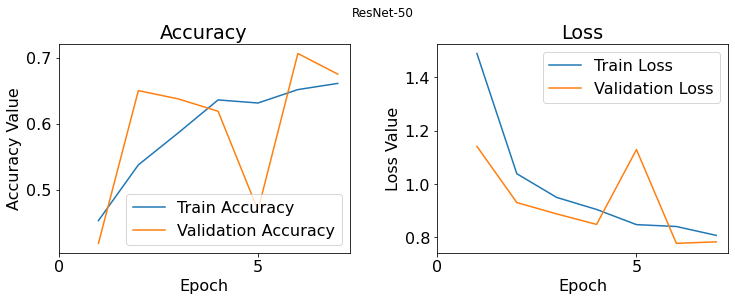

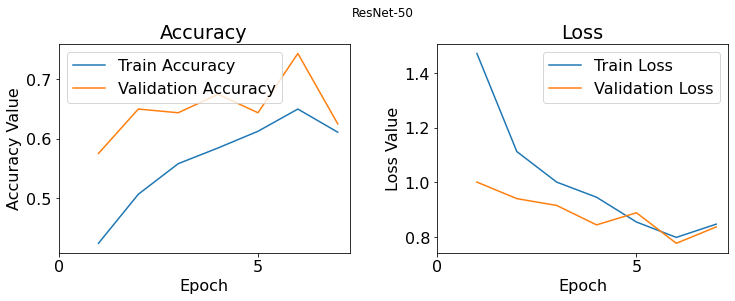

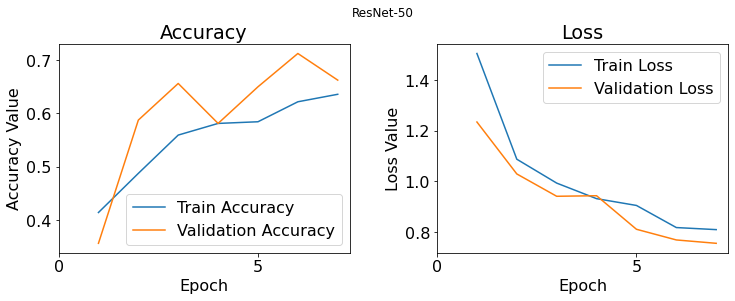

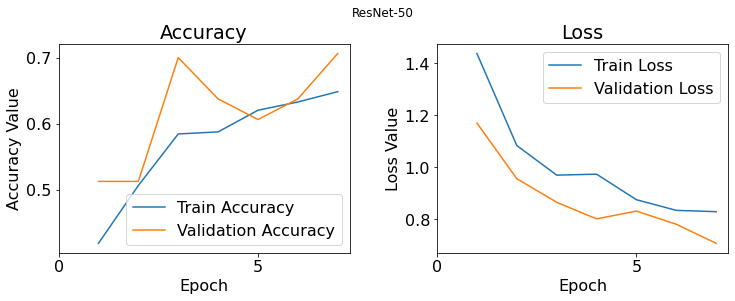

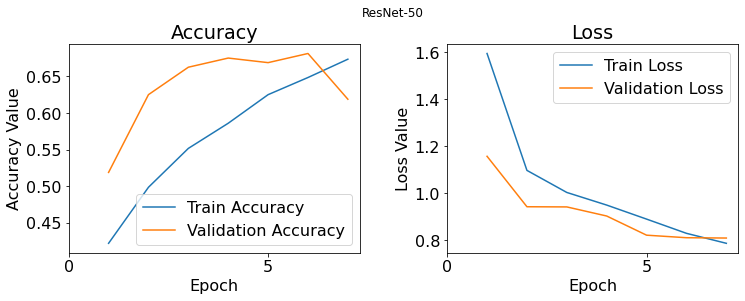

In [59]:
trainModelDF(
    train,
    pretrainedModel = "ResNet-50", #ResNet-50
    fineTune = False,
    batch_size =4,
    cross_validation_folds = 5,
    learning_rate = 0.001,
    activation = 'relu',
    number_of_hidden_layers = 1,
    optimizer = 'Adam',
    epochs = 7
)

**ResNet-50 with fine tuning last 2 layers**

In [ ]:
# trainModelDF(
#     train,
#     pretrainedModel = "ResNet-50", #ResNet-50
#     fineTune = True,
#     batch_size = 4,
#     cross_validation_folds = 5,
#     learning_rate = 0.001,
#     activation = 'relu',
#     number_of_hidden_layers = 1,
#     optimizer = 'Adam',
#     epochs = 10
# )

In [60]:
def trainFinalModel(images, pretrainedModel, fineTune, epochs, batch_size, learning_rate, activation, number_of_hidden_layers, optimizer):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rescale=1./255)
    
    print("======================================")    
    model = createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs)
    print("======================================")
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=images,
                                                        directory="../input/brain-tumor-mri-dataset/",
                                                        x_col="file",
                                                        y_col="category",
                                                        batch_size=batch_size,
                                                        seed=SEED,
                                                        shuffle=True,
                                                        class_mode="categorical",
                                                        target_size=(HEIGHT, WIDTH));
        
    print (train_generator.class_indices)
    
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    
    #Trains the model on data generated batch-by-batch by a Python generator
    model.fit(              train_generator,\
                            steps_per_epoch=STEP_SIZE_TRAIN, \
                            epochs=epochs, \
                            verbose=1)#, \
#                           callbacks = get_callbacks(patience=2))
        
    model.save("/kaggle/working/best_model")
    
    return train_generator.class_indices

In [61]:
#predict values 
def predict_createSubmission(class_indices):
    print("Predicting......")
    
    datagen_test = ImageDataGenerator(rescale=1./255)
    
    test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                        directory="../input/brain-tumor-mri-dataset/",
                                                        x_col="file",
                                                        y_col=None,
                                                        batch_size=1,
                                                        seed=SEED,
                                                        shuffle=False,
                                                        class_mode=None,
                                                        target_size=(HEIGHT, WIDTH));
        
    model = load_model('/kaggle/working/best_model')
    filenames = test_generator.filenames
    nb_samples = len(filenames)

    predictions = model.predict(test_generator,steps = nb_samples) # return prob of each class per image (softmax)
    
    predicted_class_indices=np.argmax(predictions,axis=1)
    
    labels = dict((v,k) for k,v in class_indices.items())
    predicted_labels = [labels[k] for k in predicted_class_indices]
    
    results=pd.DataFrame({"file":filenames,
                          "species":predicted_labels})

    print (results)
    
    results.to_csv("submission.csv",index=False)

    print("Prediction Completed")

In [62]:
class_indices = trainFinalModel(
    train,
    pretrainedModel = "VGG-19", #ResNet-50
    fineTune = False,
    batch_size = 32,
    learning_rate = 0.001,
    activation = 'relu',
    number_of_hidden_layers = 2,
    optimizer = 'Adam',
    epochs = 5
)

Train Model
Create Model
Found 800 validated image filenames belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Epoch 1/5
25/25 [==============================] - 86s 3s/step - loss: 1.4743 - accuracy: 0.4475
Epoch 2/5
25/25 [==============================] - 85s 3s/step - loss: 0.7562 - accuracy: 0.6913
Epoch 3/5
25/25 [==============================] - 85s 3s/step - loss: 0.5364 - accuracy: 0.7725
Epoch 4/5
25/25 [==============================] - 84s 3s/step - loss: 0.4905 - accuracy: 0.8050
Epoch 5/5
25/25 [==============================] - 84s 3s/step - loss: 0.4510 - accuracy: 0.8200


2022-10-30 15:11:18.572449: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
